In [1]:
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax
from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
import csv
import sys
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy
from functools import partial


from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))
config.update('jax_debug_nans', True)
from SSN_classes_jax_A import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters, create_gratings, param_ratios, plot_results
from training_script import train_SSN_vmap

#initialize key
key = random.PRNGKey(9)

jax backend cpu


In [2]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0, jitter_val = 5)
stimuli_pars.update(general_pars)

In [3]:
#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    A=None
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
#sigEI, sigII = .2, .2
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
filter_pars.update(general_pars) 

#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)

#Excitatory and inhibitory constants for extra synaptic GABA
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25

#key, _ = random.split(key)
#w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
w_sig = numpy.random.normal(size=(N_neurons,)) / np.sqrt(N_neurons)
#w_sig = np.zeros((N_neurons))
b_sig = 0.0


#New parameter definition
ssn_layer_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2,  c_E = c_E, c_I = c_I)
readout_pars = dict(w_sig = w_sig, b_sig=b_sig)

#Convergence parameters
conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 1000, verbose=False, silent=True)

loss_pars = dict(lambda_1=1, lambda_2=1, lambda_w= 1.5, lambda_b=1)

readout_pars['w_sig'] = np.asarray([ 0.0627244 ,  0.05022149,  0.28142756, -0.3842674 ,
               0.07741567,  0.04735875, -0.00337823,  0.53064704,
               0.03973004,  0.01521424,  0.1682218 ,  0.41124663,
              -0.11752282,  0.14196584, -0.35843202, -0.00715361,
               0.12387822,  0.16073471, -0.1220779 , -0.18964277,
              -0.35380626,  0.04589654,  0.14092311,  0.0312677 ,
               0.04696352])

In [4]:
class conn_pars():
    PERIODIC = False
    p_local = [0.4, 0.7]
    sigma_oris = 1000
    
class filter_pars():
    sigma_g = numpy.array(0.5)
    conv_factor = numpy.array(2)
    k = numpy.array(1.0471975511965976)
    edge_deg = numpy.array( 3.2)
    degree_per_pixel = numpy.array(0.05)
    
class conv_pars:
    dt = 1
    xtol = 1e-05
    Tmax = 1000
    verbose = False
    silent = True

class loss_pars:
    lambda_1 = 1
    lambda_2 = 1
    lambda_w = 1
    lambda_b = 1
    
    
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
ssn_pars.A=ssn.A

In [5]:
#Number of epochs
epochs = 500
num_epochs_to_save =51
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)
epochs_to_save = np.insert(epochs_to_save, 0, 0)

eta=10e-4
sig_noise = 2.5
offset = 2
batch_size = 50

In [6]:
def plot_losses(training_losses, validation_losses, epochs_to_save):
    plt.plot(training_losses.T, label = ['Binary cross entropy', 'Avg_dx', 'R_max', 'w', 'b', 'Training total'] )
    plt.plot(epochs_to_save, validation_losses, label='Validation')
    plt.legend()
    plt.title('Training losses')
    plt.show()
    
    
def plot_results(results_file, title=None):
    
    results = pd.read_csv(results_file, header = 0)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

    results.plot(x='epoch', y=["J_EE", "J_EI", "J_IE", "J_II"], ax=axes[0,0])
    results.plot(x='epoch', y=["s_EE", "s_EI", "s_IE", "s_II"], ax = axes[0,1])
    results.plot(x='epoch', y=["c_E", "c_I"], ax = axes[1,0])
    results.plot(x='epoch', y = ['val_accuracy', 'ber_acc'], ax = axes[1,1])
 
    
    if title:
        fig.suptitle(title)
    fig.show()
    
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data


def save_params_dict(ssn_layer_pars, readout_pars , true_acc, ber_acc, epoch ):
    
    J_2x2, s_2x2 = exponentiate(ssn_layer_pars)
     
    save_params= dict(val_accuracy= true_acc, 
                      ber_acc = ber_acc,
                J_EE= J_2x2[0,0], J_EI = J_2x2[0,1], 
                              J_IE = J_2x2[1,0], J_II = J_2x2[1,1], 
                s_EE= s_2x2[0,0], s_EI = s_2x2[0,1], 
                              s_IE = s_2x2[1,0], s_II = s_2x2[1,1],
                c_E = ssn_layer_pars['c_E'], c_I = ssn_layer_pars['c_I'], 
                 epoch = epoch, w_sig = readout_pars['w_sig'], b_sig=readout_pars['b_sig'])
    
    return save_params

def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def sigmoid(x, epsilon = 0.001):
    '''
    Introduction of epsilon stops asymptote from reaching 1 (avoids NaN)
    '''
    sig = 1/(1+np.exp(x))
    
    return (1 - 2*epsilon)*sig + epsilon

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    return J_2x2, s_2x2

def our_max(x, beta=1):
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val

def obtain_fixed_point(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100):
    
    r_init = np.zeros(ssn_input.shape[0])
    
    dt = conv_pars.dt
    xtol = conv_pars.xtol
    Tmax = conv_pars.Tmax
    verbose = conv_pars.verbose
    silent = conv_pars.silent
    
    #Find fixed point  
    
    fp, _, avg_dx = ssn.fixed_point_r(ssn_input, r_init=r_init, dt=dt, xtol=xtol, Tmax=Tmax, verbose = verbose, silent=silent)
    avg_dx = np.maximum(0, (avg_dx -1))
    
    #Apply bounding box to data
    x_box = ssn.apply_bounding_box(fp, size=3.2)
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    
    return x_box, r_max, avg_dx

@partial(jax.jit, static_argnums=[2, 3, 4, 6, 7, 8, 9, 10])
def model(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise, Rmax_E = 50, Rmax_I = 100):
    
    J_2x2, s_2x2 = exponentiate(ssn_layer_pars)
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(ssn_layer_pars['c_E'], ssn_layer_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Find the fixed point 
    x_ref, r_max_ref, avg_dx_ref = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
    x_target, r_max_target, avg_dx_target = obtain_fixed_point(ssn, SSN_input_target, conv_pars)
    
    #Add additional noise before sigmoid layer
    if sig_noise:
        delta_x = x_ref.ravel() - x_target.ravel() + sig_noise*numpy.random.normal(size=((x_target.ravel()).shape))
    else:
        delta_x = x_ref.ravel() - x_target.ravel() 
    
    #Apply sigmoid function 
    x = sigmoid(np.dot(readout_pars['w_sig'], (delta_x)) + readout_pars['b_sig'])
    
    #Calculate losses
    loss_binary=binary_loss(train_data['label'], x)
    loss_avg_dx = loss_pars.lambda_1*(avg_dx_ref + avg_dx_target)/2
    loss_r_max =  loss_pars.lambda_2*(r_max_ref + r_max_target)/2
    loss_w = loss_pars.lambda_w*(np.linalg.norm(readout_pars['w_sig'])**2)
    loss_b = loss_pars.lambda_b*(readout_pars['b_sig']**2)
    
    #Combine loss with maximum rate and dx value
    loss = loss_binary + loss_avg_dx +  loss_r_max  + loss_b  + loss_w
    
    #Find predicted label using Bernoulli distribution
    pred_label = np.round(x) 
    
    if bernoulli==True:
        key_int = numpy.random.randint(low = 0, high =  10000)
        key = random.PRNGKey(key_int)
        pred_label_b = np.sum(jax.random.bernoulli(key, p=x, shape=None))
        pred_label = [pred_label, pred_label_b]
        
    all_losses = np.vstack((loss_binary, loss_avg_dx, loss_r_max, loss_w, loss_b, loss))
    
    return loss, all_losses, pred_label

def loss(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise):
    
    '''
    Calculate parallelized loss for batch of data through vmap.
    Output:
        mean loss of all the input images
    '''
    
    vmap_model = vmap(model, in_axes = ({'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None}, {'b_sig': None, 'w_sig': None}, None, None, None,  {'ref':0, 'target':0, 'label':0}, None, None, None, None, None) )                   
    total_loss, all_losses, _ = vmap_model(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
    loss= np.sum(total_loss)
    all_losses = np.mean(all_losses, axis = 0)
    
    return loss, all_losses


def vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise):
    
    eval_vmap = vmap(model, in_axes = ({'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None}, {'b_sig': None, 'w_sig': None}, None, None, None,  {'ref':0, 'target':0, 'label':0}, None, None, None, None, None) )
    losses, _, pred_labels = eval_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
    
    if bernoulli ==True:
        true_acc = np.sum(test_data['label'] == pred_labels[0])/len(test_data['label']) 
        ber_acc = np.sum(test_data['label'] == pred_labels[1])/len(test_data['label']) 
        accs = [true_acc, ber_acc]
    else:
        accs = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, true_acc, ber_acc


def separate_train_SSN_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars, conv_pars, loss_pars, epochs_to_save, opt, results_filename = None, batch_size=20, test_size = 100, ref_ori = 55, offset = 5, epochs=1, eta=10e-4, early_stop=0.7, bernoulli = False, sig_noise = None):
    
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
   
    #Initialise optimizer
    optimizer = optax.adam(eta)
    if opt=='readout':
        opt_state = optimizer.init(readout_pars)
    if opt=='ssn':
        opt_state = optimizer.init(ssn_layer_pars)
    
    print('Training model with learning rate {}, sig_noise {} at offset {}, lam_w {}'.format(eta, sig_noise, offset, loss_pars.lambda_w))
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = test_size, offset = offset, ref_ori = ref_ori)
    val_loss, true_acc, ber_acc = vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars, conv_pars, loss_pars, bernoulli, sig_noise)
    print('Before training  -- loss: {}, true accuracy: {}, Bernoulli accuracy: {} '.format(val_loss, true_acc, ber_acc))
    val_loss_per_epoch.append(val_loss)
    
    #Save initial parameters
    save_params = save_params_dict(ssn_layer_pars, readout_pars, true_acc, ber_acc, epoch=0)
    
    #Initialise csv file
    if results_filename:
        results_handle = open(results_filename, 'w')
        results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
        results_writer.writeheader()
        results_writer.writerow(save_params)
        print('Saving results to csv ', results_filename)
    else:
        print('#### NOT SAVING!!#####')
    
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient + apply SGD
        if opt=='readout':
            epoch_loss, grad =jax.value_and_grad(loss, argnums=1, has_aux=True)(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
            updates, opt_state = optimizer.update(grad, opt_state)
            readout_pars = optax.apply_updates(readout_pars, updates)
            
        if opt=='ssn':
            epoch_loss, grad =jax.value_and_grad(loss, argnums=0, has_aux = True)(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
            updates, opt_state = optimizer.update(grad, opt_state)
            ssn_layer_pars = optax.apply_updates(ssn_layer_pars, updates)
        
        #Stack all training losses
        if epoch==1:
            all_losses = epoch_loss[1]
        else:
            all_losses = np.hstack((all_losses, epoch_loss[1]))
        
        
        epoch_time = time.time() - start_time

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = test_size, offset = offset, ref_ori = ref_ori)
            val_loss, true_acc, ber_acc= vmap_eval(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise)
            print('Training loss: {} ¦ Validation -- loss: {}, true accuracy: {}, Bernoulli accuracy: {},  at epoch {}, (time {})'.format(epoch_loss[0], val_loss, true_acc, ber_acc, epoch, epoch_time))
            val_loss_per_epoch.append(val_loss)
            
            #Create dictionary of parameters to save
            save_params = save_params_dict(ssn_layer_pars, readout_pars, true_acc, ber_acc, epoch)
            
            #Write results in csv file
            if results_filename:
                results_writer.writerow(save_params)
                
           #Early stop to train readout layer 
            if true_acc>= early_stop and opt=='readout':
                print('Early stop: {} accuracy achieved'.format(early_stop))
                break
    
    return ssn_layer_pars, readout_pars, val_loss_per_epoch, all_losses

In [15]:
opt='readout'
results = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/fixed_w_readout_train70.csv'
new_ssn_layer_pars, new_readout_pars, val_loss_test, training_los_test= separate_train_SSN_vmap(ssn_layer_pars, readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, loss_pars, epochs_to_save=epochs_to_save, opt=opt,  results_filename=results, ref_ori = 55, offset = offset, batch_size = batch_size, epochs = epochs, early_stop = 0.6, sig_noise=sig_noise, eta = eta, bernoulli = True)

Training model with learning rate 0.001, sig_noise 2.5 at offset 2, lam_w 1
Before training  -- loss: 1.9468508958816528, true accuracy: 0.5699999928474426, Bernoulli accuracy: 0.46000000834465027 
Saving results to csv  /mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/fixed_w_readout_train70.csv
Training loss: 96.76152038574219 ¦ Validation -- loss: 2.697194814682007, true accuracy: 0.41999998688697815, Bernoulli accuracy: 0.3799999952316284,  at epoch 1, (time 1.404146671295166)
Training loss: 212.91665649414062 ¦ Validation -- loss: 2.7262797355651855, true accuracy: 0.3199999928474426, Bernoulli accuracy: 0.5799999833106995,  at epoch 10, (time 1.4077308177947998)
Training loss: 186.14785766601562 ¦ Validation -- loss: 2.675206184387207, true accuracy: 0.3799999952316284, Bernoulli accuracy: 0.5199999809265137,  at epoch 20, (time 1.393766164779663)
Training loss: 145.77928161621094 ¦ Validation -- loss: 2.3667945861816406, true accuracy: 0.47999998927

In [10]:
readout_pars

{'w_sig': DeviceArray([ 0.0627244 ,  0.05022149,  0.28142756, -0.3842674 ,
               0.07741567,  0.04735875, -0.00337823,  0.53064704,
               0.03973004,  0.01521424,  0.1682218 ,  0.41124663,
              -0.11752282,  0.14196584, -0.35843202, -0.00715361,
               0.12387822,  0.16073471, -0.1220779 , -0.18964277,
              -0.35380626,  0.04589654,  0.14092311,  0.0312677 ,
               0.04696352], dtype=float32),
 'b_sig': 0.0}

In [16]:
new_readout_pars

{'b_sig': DeviceArray(-0.06537655, dtype=float32),
 'w_sig': DeviceArray([ 0.12605566,  0.1273912 ,  0.18054508, -0.27392012,
              -0.01211993, -0.03041697,  0.0826202 ,  0.41804752,
               0.1202573 , -0.03632501,  0.18295377,  0.30918923,
              -0.1940052 ,  0.20544377, -0.2499748 , -0.08071887,
               0.19058336,  0.03633068, -0.02569352, -0.16947141,
              -0.2595211 , -0.04320447,  0.13482924, -0.05088398,
               0.1140677 ], dtype=float32)}

In [22]:
batch_size

50

In [17]:
opt='ssn'
results_fixed = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/fixed_w_ssn_train70.csv'
new_ssn_layer_pars, new_readout_pars, val_loss_test, training_los_test= separate_train_SSN_vmap(ssn_layer_pars, new_readout_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, loss_pars, epochs_to_save=epochs_to_save, opt=opt,  results_filename=results_fixed, ref_ori = 55, offset = offset, batch_size = batch_size, epochs = epochs, sig_noise=sig_noise, eta = eta, bernoulli = True)

Training model with learning rate 0.001, sig_noise 2.5 at offset 2, lam_w 1
Before training  -- loss: 1.6479710340499878, true accuracy: 0.44999998807907104, Bernoulli accuracy: 0.44999998807907104 
Saving results to csv  /mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/fixed_w_ssn_train70.csv
Training loss: 81.46697998046875 ¦ Validation -- loss: 1.4926507472991943, true accuracy: 0.699999988079071, Bernoulli accuracy: 0.46000000834465027,  at epoch 1, (time 25.31122398376465)
Training loss: 74.39445495605469 ¦ Validation -- loss: 1.474316120147705, true accuracy: 0.6600000262260437, Bernoulli accuracy: 0.5199999809265137,  at epoch 10, (time 3.1006534099578857)
Training loss: 72.08554077148438 ¦ Validation -- loss: 1.4416948556900024, true accuracy: 0.699999988079071, Bernoulli accuracy: 0.5,  at epoch 20, (time 3.110403299331665)
Training loss: 72.65719604492188 ¦ Validation -- loss: 1.437783122062683, true accuracy: 0.7400000095367432, Bernoulli accura

Training loss: 53.47041320800781 ¦ Validation -- loss: 1.0722767114639282, true accuracy: 1.0, Bernoulli accuracy: 0.9399999976158142,  at epoch 440, (time 3.2717368602752686)
Training loss: 53.00236511230469 ¦ Validation -- loss: 1.0487487316131592, true accuracy: 1.0, Bernoulli accuracy: 1.0,  at epoch 450, (time 3.2706425189971924)
Training loss: 51.76158905029297 ¦ Validation -- loss: 1.0286957025527954, true accuracy: 1.0, Bernoulli accuracy: 0.9800000190734863,  at epoch 460, (time 3.2540087699890137)
Training loss: 51.473411560058594 ¦ Validation -- loss: 1.0228466987609863, true accuracy: 1.0, Bernoulli accuracy: 0.9599999785423279,  at epoch 470, (time 3.68186092376709)
Training loss: 51.282325744628906 ¦ Validation -- loss: 1.027649164199829, true accuracy: 1.0, Bernoulli accuracy: 1.0,  at epoch 480, (time 3.232919216156006)
Training loss: 51.68775939941406 ¦ Validation -- loss: 1.0196802616119385, true accuracy: 1.0, Bernoulli accuracy: 0.9800000190734863,  at epoch 490, (t

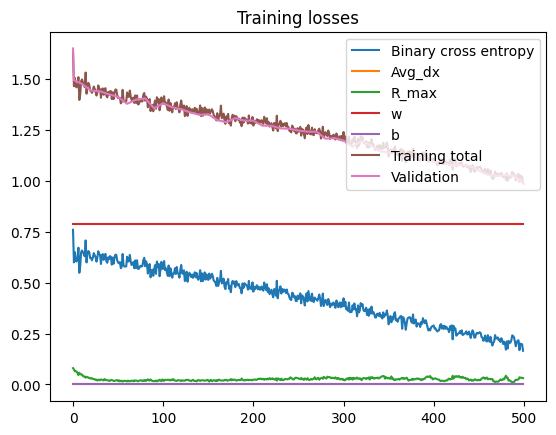

In [18]:
plot_losses(training_los_test, val_loss_test, epochs_to_save)

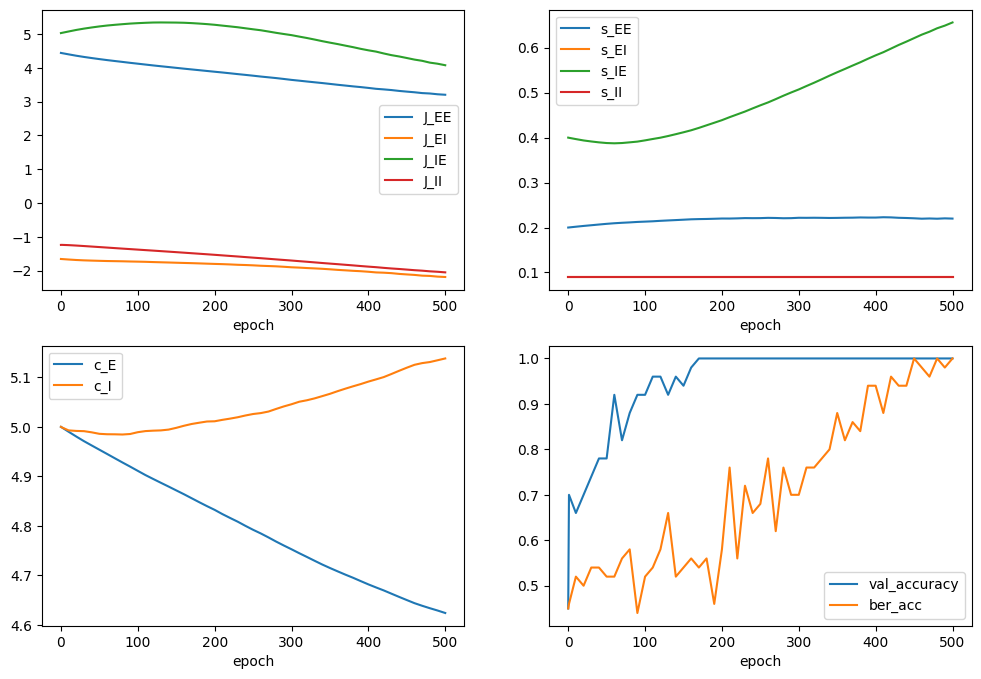

In [20]:
plot_results(results_fixed)

In [23]:
param_ratios(results_fixed)

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [-27  32 -18  65]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[1.0995033049751652 1.0 1.6404192499999999 1.0]
s ratios =  [ 9  0 64  0]


In [ ]:
def plot_results(results_file, title=None):
    
    results = pd.read_csv(results_file, header = 0)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

    results.plot(x='epoch', y=["J_EE", "J_EI", "J_IE", "J_II"], ax=axes[0,0])
    results.plot(x='epoch', y=["s_EE", "s_EI", "s_IE", "s_II"], ax = axes[0,1])
    results.plot(x='epoch', y=["c_E", "c_I"], ax = axes[1,0])
    results.plot(x='epoch', y = ['val_accuracy'], ax = axes[1,1])
 
    
    if title:
        fig.suptitle(title)
    fig.show()
    
plot_results(results)

## Test accuracy of pretraining

100


(array([ 2.,  2.,  3., 12., 14., 27., 14., 12.,  9.,  5.]),
 array([0.37      , 0.39199999, 0.414     , 0.43599999, 0.458     ,
        0.47999999, 0.50199997, 0.52399999, 0.546     , 0.56799996,
        0.58999997]),
 <BarContainer object of 10 artists>)

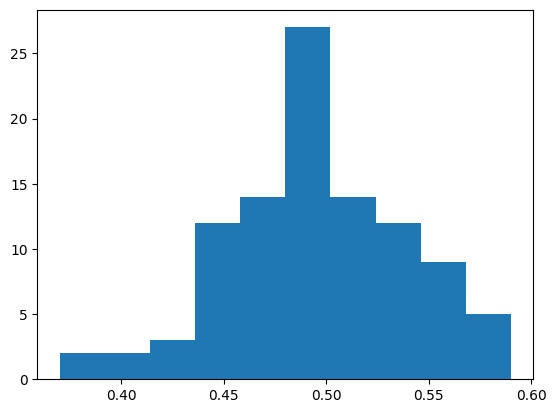

In [30]:
list_accs = []
for i in range(0,100):
    test_data = create_data(stimuli_pars, number = 100, offset = 10, ref_ori = 55)
    _, true_acc, _= vmap_eval(ssn_layer_pars, new_readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli=True, sig_noise=sig_noise)
    list_accs.append(true_acc)

list_accs = np.asarray(list_accs)
print(len(list_accs))
plt.hist(list_accs)

## Proof of concept model

Using trained readout layer -> quantify effects of changing different parameters

In [ ]:
test_data = create_data(stimuli_pars, number = 500, offset = 10, ref_ori = 55)
_, true_acc, _= vmap_eval(ssn_layer_pars, new_readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli=True, sig_noise=2)

In [ ]:
Js0 = [1.82650658, 0.681944750, 2.06815311, 0.5106321]
J_2x2 = make_J2x2(*Js0)
ssn_layer_pars['logJ_2x2'] = np.log(J_2x2*signs)

val_loss, true_acc, ber_acc= vmap_eval(ssn_layer_pars, new_readout_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli=True, sig_noise=2)
val_loss, true_acc, ber_acc

In [ ]:
new_readout_pars['w_sig']

In [ ]:
new_readout_pars['w_sig'] # weights 2